In [2]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torchvision.transforms import functional as F
import torchvision.transforms as T
import torchvision.models as models

from pytorch_msssim import ssim as ssim_fn
from pytorch_msssim import ms_ssim as ms_ssim_fn
from torchmetrics.image import PeakSignalNoiseRatio

import random

from tqdm.notebook import tqdm

In [3]:
SEED = 1834579290

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Conf:
    image_dir = '/kaggle/input/xray-bone-shadow-supression/augmented/augmented'
    batch_size = 8
    image_size = 256

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, set_type="train"):
        self.image_dir = image_dir
        self.x_image_dir = os.listdir(os.path.join(image_dir, 'source'))
        self.y_image_dir = os.listdir(os.path.join(image_dir, 'target'))

        self.to_tensor = T.ToTensor()

        data_len = len(self.x_image_dir)
        train_size = data_len * 0.8
        val_size = data_len * 0.15

        train_ptr = train_size
        val_ptr = train_size + val_size

        data_a, data_b = 0, 0

        if set_type == "train":
            data_a, data_b = 0, train_ptr
        elif set_type == "val":
            data_a, data_b = train_ptr, val_ptr
        else:
            data_a, data_b = val_ptr, data_len
        
        self.x_image_dir = self.x_image_dir[int(data_a):int(data_b)]
        self.y_image_dir = self.y_image_dir[int(data_a):int(data_b)]
        
    def __len__(self):
        return len(self.x_image_dir)

    def __getitem__(self, idx):
        x_img_path = os.path.join(self.image_dir, "source", self.x_image_dir[idx])
        y_img_path = os.path.join(self.image_dir, "target", self.y_image_dir[idx])
        
        x_image = Image.open(x_img_path).convert('L')
        y_image = Image.open(y_img_path).convert('L')

        x_image = x_image.resize((Conf.image_size, Conf.image_size), Image.BICUBIC)
        y_image = y_image.resize((Conf.image_size, Conf.image_size), Image.BICUBIC)

        x_tensor = self.to_tensor(x_image)
        y_tensor = self.to_tensor(y_image)

        return x_tensor, y_tensor

In [5]:
%%time

train_dataset = ImageDataset(Conf.image_dir, "train")
val_dataset = ImageDataset(Conf.image_dir, "val")
test_dataset = ImageDataset(Conf.image_dir, "test")

train_loader = DataLoader(train_dataset, batch_size = Conf.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = Conf.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = Conf.batch_size, shuffle=False)

CPU times: user 1.26 ms, sys: 7.73 ms, total: 9 ms
Wall time: 91.3 ms


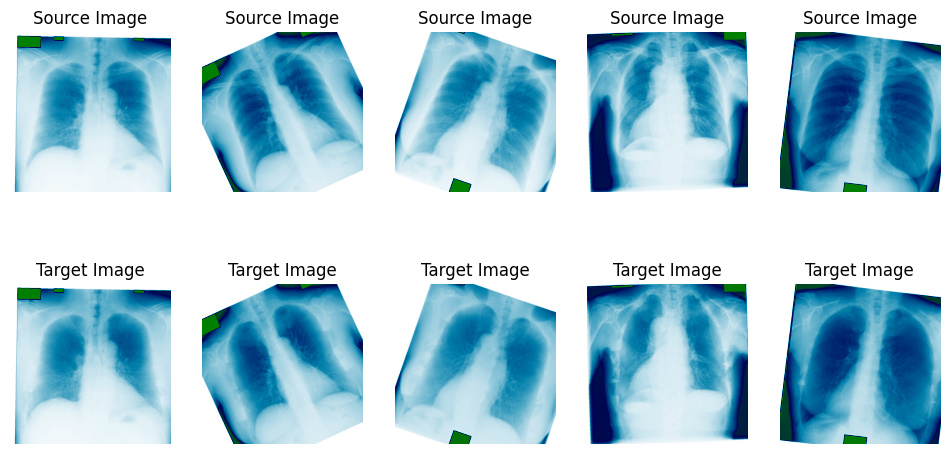

In [17]:
cmap = "ocean_r"
def display_samples(loader, num_samples=5):
    samples_displayed = 0
    plt.figure(figsize=(12, 6))
    for x, y in loader:
        for i in range(x.size(0)):
            if samples_displayed >= num_samples:
                plt.show()
                return
            
            plt.subplot(2, num_samples, samples_displayed + 1)
            plt.imshow(x[i].permute(1, 2, 0).numpy(), cmap=cmap)
            plt.title("Source Image")
            plt.axis('off')

            plt.subplot(2, num_samples, samples_displayed + 1 + num_samples)
            plt.imshow(y[i].permute(1, 2, 0).numpy(), cmap=cmap)
            plt.title("Target Image")
            plt.axis('off')
            
            samples_displayed += 1

display_samples(test_loader)

In [7]:
class Gaussian(nn.Module):
    def __init__(self):
        super(Gaussian, self).__init__()

    def forward(self, x):
        return torch.exp(-x**2)

class XUnit(nn.Module):
    def __init__(self, in_channels, kernel_size=9, g=True):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, 
            in_channels, 
            kernel_size=kernel_size, 
            padding=kernel_size // 2,
            groups=in_channels, 
            bias=True
        )
        self.G = Gaussian() if g else nn.Sigmoid()

    def forward(self, x):
        out = nn.functional.relu(x)
        out = self.depthwise(out)
        out = self.G(out)
        out = out * x
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            dilation=dilation, 
            padding=dilation,
            bias=True
        )
        self.x_unit = XUnit(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.x_unit(x)
        return x
        
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super().__init__()
        self.conv_block = ConvBlock(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=1, 
            dilation=dilation
        )

    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, level=1):
        super().__init__()
        
        dilation_c1 = 2 if (level == 3) else 1
        dilation_c2c3 = 2**(level-1)
        dilation_bn = 2**(level+1)
        dilation_d1 = 2 if (level == 3) else 1
        
        self.c1 = ConvBlock(in_channels, out_channels, dilation=dilation_c1)
        self.c2 = ConvBlock(out_channels, out_channels, dilation=dilation_c2c3)
        self.c3 = ConvBlock(out_channels, out_channels, dilation=dilation_c2c3)
        
        self.bn = ConvBlock(out_channels, out_channels, dilation=dilation_bn)
        
        self.d3 = UpBlock(2 * out_channels, out_channels, dilation=dilation_c2c3)
        self.d2 = UpBlock(2 * out_channels, out_channels, dilation=dilation_c2c3)
        self.d1 = UpBlock(2 * out_channels, out_channels, dilation=dilation_d1)

    def forward(self, x):
        c1 = self.c1(x)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        
        bn = self.bn(c3)
        
        d3 = self.d3(bn, c3)
        d2 = self.d2(d3, c2)
        d1 = self.d1(d2, c1)
        return d1
class xU_NetFullSharp(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.f = [8, 16, 32, 64, 128]
        
        self.encoder_1_1 = EncoderBlock(in_channels, self.f[0], level=1)
        self.encoder_2_1 = EncoderBlock(self.f[0], self.f[1], level=1)
        self.encoder_3_1 = EncoderBlock(self.f[1], self.f[2], level=2)
        self.encoder_4_1 = EncoderBlock(self.f[2], self.f[3], level=2)
        self.encoder_5_1 = EncoderBlock(self.f[3], self.f[4], level=3)
        
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool_4x4 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.maxpool_8x8 = nn.MaxPool2d(kernel_size=8, stride=8)

        self.conv1_2 = ConvBlock(self.f[1] + self.f[0], self.f[0])
        self.conv2_2 = ConvBlock(self.f[2] + self.f[1] + self.f[0], self.f[1])
        self.conv1_3 = ConvBlock(self.f[1] + self.f[0] * 2 + self.f[2], self.f[0])
        self.conv3_2_1 = ConvBlock(self.f[0] + self.f[1], self.f[2] * 2)
        self.conv3_2 = ConvBlock(self.f[3] + self.f[2] + self.f[2] * 2, self.f[2])
        self.conv2_3 = ConvBlock(self.f[2] + self.f[1] * 2 + self.f[3] + self.f[0], self.f[1])
        self.conv1_4_1 = ConvBlock(self.f[3] + self.f[2], self.f[0] * 2)
        self.conv1_4 = ConvBlock(self.f[1] + self.f[0] * 5, self.f[0])
        self.conv4_2_1 = ConvBlock(self.f[2] + self.f[1] + self.f[0], self.f[3] * 3)
        self.conv4_2 = ConvBlock(self.f[4] + self.f[3] * 4, self.f[3])
        self.conv3_3_1 = ConvBlock(self.f[1] + self.f[0], self.f[2] * 2)
        self.conv3_3 = ConvBlock(self.f[3] + self.f[2] * 2 + self.f[4] + self.f[2] * 2, self.f[2])
        self.conv2_4_1 = ConvBlock(self.f[3] + self.f[4], self.f[1] * 2)
        self.conv2_4 = ConvBlock(self.f[2] + self.f[1] * 5 + self.f[0], self.f[1])
        self.conv1_5_1 = ConvBlock(self.f[2] + self.f[3] + self.f[4], self.f[0] * 3)
        self.conv1_5 = ConvBlock(self.f[1] + self.f[0] * 7, self.f[0])
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        self.up8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)
        self.up16 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)
        
        self.out_conv = nn.Conv2d(self.f[0], out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        conv1_1 = self.encoder_1_1(x)
        pool1_1_1 = self.maxpool_2x2(conv1_1)
        pool1_1_2 = self.maxpool_4x4(conv1_1)
        pool1_1_3 = self.maxpool_8x8(conv1_1)
        
        conv2_1 = self.encoder_2_1(pool1_1_1)
        pool2_1_1 = self.maxpool_2x2(conv2_1)
        pool2_1_2 = self.maxpool_4x4(conv2_1)
        
        up1_2 = self.up2(conv2_1)
        conv1_2_in = torch.cat([up1_2, conv1_1], dim=1)
        conv1_2 = self.conv1_2(conv1_2_in)
        pool1_2_1 = self.maxpool_2x2(conv1_2)
        pool1_2_2 = self.maxpool_4x4(conv1_2)
        
        conv3_1 = self.encoder_3_1(pool2_1_1)
        pool3 = self.maxpool_2x2(conv3_1)
        conv3_1_1_3 = self.up4(conv3_1)
        
        up2_2 = self.up2(conv3_1)
        conv2_2_in = torch.cat([up2_2, conv2_1, pool1_1_1], dim=1)
        conv2_2 = self.conv2_2(conv2_2_in)
        pool2_2_1 = self.maxpool_2x2(conv2_2)
        
        up1_3 = self.up2(conv2_2)
        conv1_3_in = torch.cat([up1_3, conv1_1, conv1_2, conv3_1_1_3], dim=1)
        conv1_3 = self.conv1_3(conv1_3_in)
        pool1_3_1 = self.maxpool_2x2(conv1_3)
            
        conv4_1 = self.encoder_4_1(pool3)
        conv4_1_2_3 = self.up4(conv4_1)
        conv4_1_1_4 = self.up8(conv4_1)
        pool4 = self.maxpool_2x2(conv4_1)
        
        up3_2 = self.up2(conv4_1)
        conv3_2_1_in = torch.cat([pool1_1_2, pool2_1_1], dim=1)
        conv3_2_1 = self.conv3_2_1(conv3_2_1_in)
        conv3_2_in = torch.cat([up3_2, conv3_1, conv3_2_1], dim=1)
        conv3_2 = self.conv3_2(conv3_2_in)

        conv3_2_1_4 = self.up4(conv3_2)

        up2_3 = self.up2(conv3_2)
        conv2_3_in = torch.cat([up2_3, conv2_1, conv2_2, conv4_1_2_3, pool1_2_1], dim=1)
        conv2_3 = self.conv2_3(conv2_3_in)
        
        up1_4 = self.up2(conv2_3)
        conv1_4_1_in = torch.cat([conv4_1_1_4, conv3_2_1_4], dim=1)
        conv1_4_1 = self.conv1_4_1(conv1_4_1_in)
        conv1_4_in = torch.cat([up1_4, conv1_1, conv1_2, conv1_3, conv1_4_1], dim=1)
        conv1_4 = self.conv1_4(conv1_4_in)
        
        conv5_1 = self.encoder_5_1(pool4)
        conv5_1_3_3 = self.up4(conv5_1)
        conv5_1_2_4 = self.up8(conv5_1)
        conv5_1_1_5 = self.up16(conv5_1)

        up4_2 = self.up2(conv5_1)
        conv4_2_1_in = torch.cat([pool3, pool2_1_2, pool1_1_3], dim=1)
        conv4_2_1 = self.conv4_2_1(conv4_2_1_in)
        conv4_2_in = torch.cat([up4_2, conv4_1, conv4_2_1], dim=1)
        conv4_2 = self.conv4_2(conv4_2_in)
        
        conv4_2_2_4 = self.up4(conv4_2)
        conv4_2_1_5 = self.up8(conv4_2)

        up3_3 = self.up2(conv4_2)
        conv3_3_1_in = torch.cat([pool2_2_1, pool1_2_2], dim=1)
        conv3_3_1 = self.conv3_3_1(conv3_3_1_in)
        conv3_3_in = torch.cat([up3_3, conv3_1, conv3_2, conv5_1_3_3, conv3_3_1], dim=1)
        conv3_3 = self.conv3_3(conv3_3_in)
        
        conv3_3_1_5 = self.up4(conv3_3)

        up2_4 = self.up2(conv3_3)
        conv2_4_1_in = torch.cat([conv4_2_2_4, conv5_1_2_4], dim=1)
        conv2_4_1 = self.conv2_4_1(conv2_4_1_in)
        conv2_4_in = torch.cat([up2_4, conv2_1, conv2_2, conv2_3, conv2_4_1, pool1_3_1], dim=1)
        conv2_4 = self.conv2_4(conv2_4_in)
        
        up1_5 = self.up2(conv2_4)
        conv1_5_1_in = torch.cat([conv3_3_1_5, conv4_2_1_5, conv5_1_1_5], dim=1)
        conv1_5_1 = self.conv1_5_1(conv1_5_1_in)
        conv1_5_in = torch.cat([up1_5, conv1_1, conv1_2, conv1_3, conv1_4, conv1_5_1], dim=1)
        conv1_5 = self.conv1_5(conv1_5_in)
        
        out = torch.sigmoid(self.out_conv(conv1_5))
        return out

In [8]:
_psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)

def mae(y_true, y_pred):
    return nn.functional.l1_loss(y_pred, y_true, reduction='mean')

def mse(y_true, y_pred):
    return nn.functional.mse_loss(y_pred, y_true, reduction='mean')

def psnr(y_true, y_pred):
    return _psnr(y_pred, y_true)

def ssim(y_true, y_pred):
    return ssim_fn(y_pred, y_true, data_range=1.0, size_average=True)

def ssim_loss(y_true, y_pred):
    return 1.0 - ssim_fn(y_pred, y_true, data_range=1.0, size_average=True)

def l1_ssim(y_true, y_pred):
    alpha = 0.84
    delta = 1.0 - alpha
    ssim_val = 1.0 - ssim_fn(y_pred, y_true, data_range=1.0, size_average=True)
    ssim_val *= alpha
    l1_val = mae(y_pred, y_true) * delta
    return ssim_val + l1_val

def ms_ssim(y_true, y_pred):
    return ms_ssim_fn(y_pred, y_true, data_range=1.0, size_average=True)

In [9]:
def visualize_example(test_loader, model, device, full_batch=False):
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            for i in range(inputs.shape[0] if full_batch else 1):
                input_image = inputs[i].cpu().permute(1, 2, 0)
                generated_image = outputs[i].cpu().permute(1, 2, 0)
                target_image = targets[i].cpu().permute(1, 2, 0)
    
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_image, cmap=cmap)
                ax[0].set_title("Input Image")
                ax[1].imshow(generated_image, cmap=cmap)
                ax[1].set_title("Generated Image")
                ax[2].imshow(target_image, cmap=cmap)
                ax[2].set_title("Target Image")
    
                plt.show()
            break

def display_metrics(metrics, data_subset="Validation"):
    print(f"  {data_subset} Metrics\n\tL1 SSIM: {metrics['l1_ssim']:.4f} | MS SSIM: {metrics['ms_ssim']:.4f} | SSIM: {metrics['ssim']:.4f} |\n\tMSE: {metrics['mse']:.4f} | MAE: {metrics['mae']:.4f} | PSNR: {metrics['psnr']:.4f} |")

In [10]:
model = xU_NetFullSharp().to(device)
model.load_state_dict(torch.load('/kaggle/input/xu-netfullsharp-paper-implementation/xU-NetFullSharp.pth', map_location=device))

<ipython-input-10-503a09fdeb95>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/xu-netfullsharp-paper-implementation/xU-NetF

<All keys matched successfully>

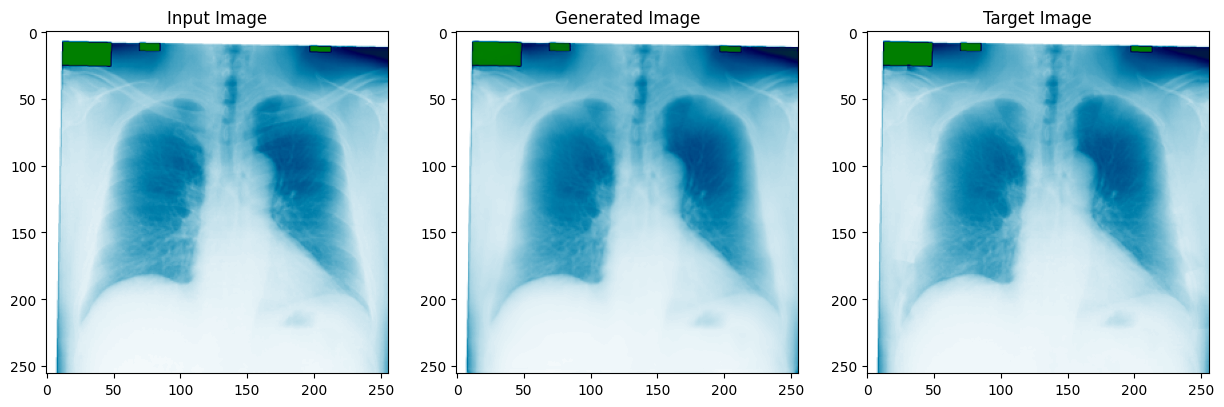

In [18]:
visualize_example(test_loader, model, device)

In [99]:
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
x.shape, y.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))

In [100]:
output = model(x)
output.shape

torch.Size([8, 1, 256, 256])

In [121]:
def display_and_crop(image1: torch.Tensor,
                     image2: torch.Tensor,
                     x: int, y: int, w: int, h: int, color: str = "red") -> None:
    
    img1_np = image1.permute(1, 2, 0).cpu().detach().numpy()
    img2_np = image2.permute(1, 2, 0).cpu().detach().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(12, 8))

    axes[0].imshow(img1_np, cmap=cmap)
    axes[0].set_title("Generated Image")
    rect1 = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
    axes[0].add_patch(rect1)

    axes[1].imshow(img2_np, cmap=cmap)
    axes[1].set_title("Target Image")
    rect2 = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
    axes[1].add_patch(rect2)

    crop1 = image1[:, y:y+h, x:x+w]
    crop2 = image2[:, y:y+h, x:x+w]

    crop1_np = crop1.permute(1, 2, 0).cpu().detach().numpy()
    crop2_np = crop2.permute(1, 2, 0).cpu().detach().numpy()

    axes[2].imshow(1 - crop1_np, cmap=cmap)
    axes[2].set_title("Generated Details")

    axes[3].imshow(1 - crop2_np, cmap=cmap)
    axes[3].set_title("Target Details")

    for ax in axes:
        ax.axis("off")
        
    plt.show()

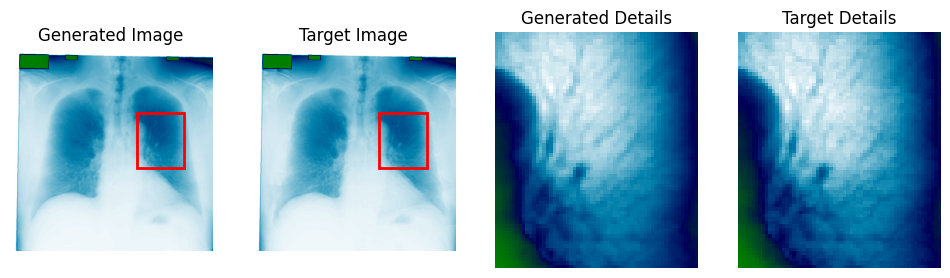

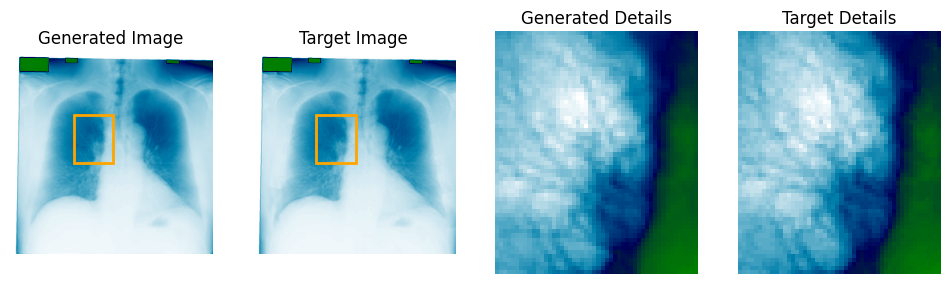

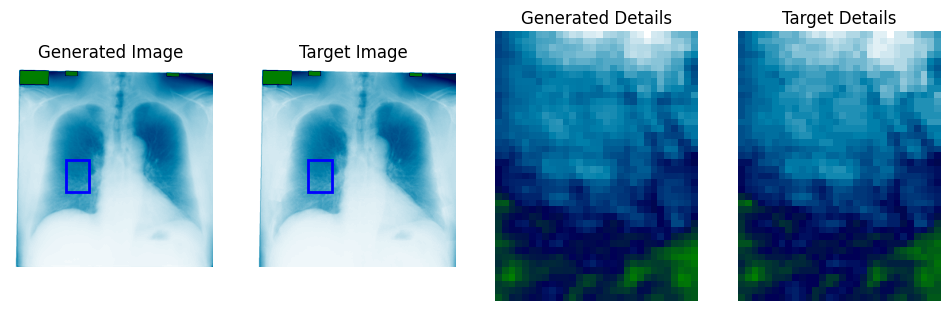

In [144]:
def display_important_regions(output: torch.Tensor, y: torch.Tensor) -> None:
    display_and_crop(output[0], y[0], 160, 80, 60, 70, "red")
    display_and_crop(output[0], y[0], 80, 80, 50, 60, "orange")
    display_and_crop(output[0], y[0], 70, 120, 30, 40, "blue")
    
display_important_regions(output, y)

In [146]:
def remove_bone_shadow(input_image: torch.Tensor, output_path: str, use_cmap: bool = False):
    input_image = input_image.to(next(model.parameters()).device)
    
    with torch.no_grad():
        output = model(input_image)
    
    output_np = output.squeeze().cpu().numpy()
    
    cmap = "ocean_r" if use_cmap else "gray"
    
    plt.figure(figsize=(6, 6))
    plt.imshow(output_np, cmap=cmap)
    plt.axis("off")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0)
    plt.close()
    
remove_bone_shadow(x[0].unsqueeze(0), "output_image", use_cmap=True)